In [2]:
import duckdb

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        if name[0] != "_":
            dfs[name] = conn.sql(f"FROM staging.{name};").df()
            duckdb.register(name, dfs[name])

TASK 1

In [14]:
# a)

a = duckdb.sql("""SELECT 
               title,
               length 
               FROM film 
               WHERE length > 180;""").df()
a.head()

,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184


In [4]:
# b)

b = duckdb.sql("""SELECT 
               title, 
               rating, 
               length, 
               description 
               FROM film 
               WHERE REGEXP_MATCHES(title, '(^| )LOVE($| )');""").df()
b

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


In [5]:
# c)
c = duckdb.sql("""SELECT 
               MIN(length) AS shortest_film, 
               MAX(length) AS longest_film, 
               AVG(length) AS average_length, 
               MEDIAN(length) AS median_length 
               FROM film;""").df()
c

,shortest_film,longest_film,average_length,median_length
0,46,185,115.272,114.0


In [ ]:
# d)
d = duckdb.sql("""--sql
               SELECT 
                title, 
                rental_rate/rental_duration AS adjusted_rate 
               FROM film 
               ORDER BY adjusted_rate DESC 
               LIMIT 10;""").df()
d

,title,adjusted_rate
0,AMERICAN CIRCUS,1.663333
1,BACKLASH UNDEFEATED,1.663333
2,BILKO ANONYMOUS,1.663333
3,BEAST HUNCHBACK,1.663333
4,CARIBBEAN LIBERTY,1.663333
5,AUTUMN CROW,1.663333
6,CASPER DRAGONFLY,1.663333
7,ACE GOLDFINGER,1.663333
8,BEHAVIOR RUNAWAY,1.663333
9,CASUALTIES ENCINO,1.663333


In [7]:
# e)
e = duckdb.sql("""SELECT 
               fa.actor_id,
               a.first_name,
               a.last_name,
               COUNT(fa.film_id) AS frequency 
               FROM actor a 
               LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id 
               GROUP BY fa.actor_id, a.first_name, a.last_name 
               ORDER BY frequency DESC 
               LIMIT 10;""").df()
e

,actor_id,first_name,last_name,frequency
0,107,GINA,DEGENERES,42
1,102,WALTER,TORN,41
2,198,MARY,KEITEL,40
3,181,MATTHEW,CARREY,39
4,23,SANDRA,KILMER,37
5,81,SCARLETT,DAMON,36
6,106,GROUCHO,DUNST,35
7,37,VAL,BOLGER,35
8,158,VIVIEN,BASINGER,35
9,60,HENRY,BERRY,35


In [8]:
# Which films in the film list does not exist in the inventory?

# Which actors are most lucrative?

# Which cities should stores close?

# Which employees should get raises?

# A store in *city burned down. What is the replacement cost for all the movies

In [9]:
# Which films in the film list does not exist in the inventory?

missing_id = duckdb.sql("""SELECT film_id FROM film
                        EXCEPT 
                        SELECT film_id FROM inventory
                        ORDER BY film_id;""").df()

print(missing_id.values.flatten())

[ 14  33  36  38  41  87 108 128 144 148 171 192 195 198 217 221 318 325
 332 359 386 404 419 495 497 607 642 669 671 701 712 713 742 801 802 860
 874 909 943 950 954 955]


In [10]:
# Which actors might be more lucrative?

lucrative_actors = duckdb.sql("""SELECT a.actor_id,
                                CONCAT(a.first_name, ' ', a.last_name) AS full_name,
                                SUM(p.amount) AS amount
                                FROM actor a
                                LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
                                LEFT JOIN film f ON fa.film_id = f.film_id
                                LEFT JOIN inventory i ON f.film_id = i.film_id
                                LEFT JOIN rental r ON i.inventory_id = r.inventory_id
                                LEFT JOIN payment p ON r.rental_id = p.rental_id
                                GROUP BY a.actor_id,full_name
                                ORDER BY amount DESC;""").df()

lucrative_actors.head()

,actor_id,full_name,amount
0,107.0,GINA DEGENERES,3442.49
1,181.0,MATTHEW CARREY,2742.19
2,198.0,MARY KEITEL,2689.25
3,81.0,SCARLETT DAMON,2655.28
4,102.0,WALTER TORN,2620.62


In [11]:
# In which cities should the stores close?

TASK 2

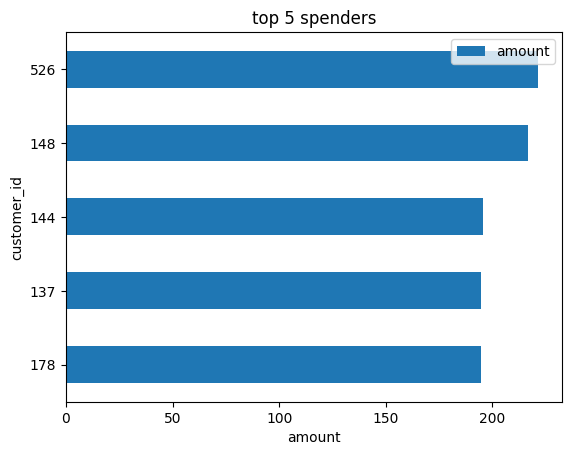

In [12]:
# a)
top_spender = duckdb.sql("""SELECT customer_id,
                         SUM(amount) AS amount 
                         FROM payment 
                         GROUP BY customer_id 
                         ORDER BY amount DESC;""").df()
ax = top_spender.head(5).plot(
    kind="barh",
    x="customer_id",
    y="amount",
    title="top 5 spenders",
    xlabel="amount",
)
ax.invert_yaxis()

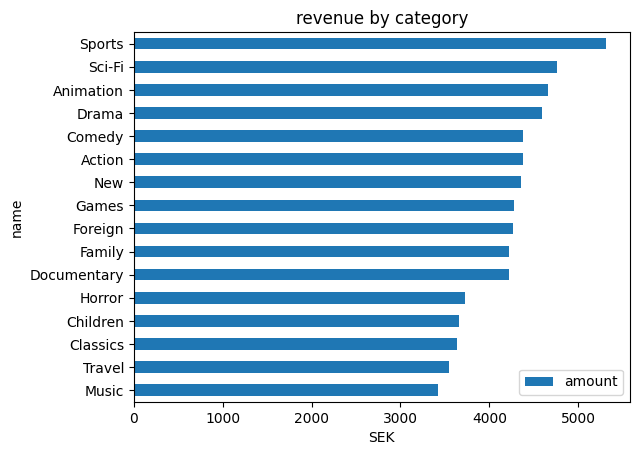

In [13]:
# b)
revenue_category = duckdb.sql("""
                                SELECT c.name,
                                SUM(p.amount) AS amount 
                                FROM category c
                                LEFT JOIN film_category fc ON c.category_id = fc.category_id
                                LEFT JOIN film f ON fc.film_id = f.film_id
                                LEFT JOIN inventory i ON f.film_id = i.film_id
                                LEFT JOIN rental r ON i.inventory_id = r.inventory_id
                                LEFT JOIN payment p ON r.rental_id = p.rental_id
                                GROUP BY c.name
                                ORDER BY amount DESC;""").df()

ax = revenue_category.plot(
    kind="barh",
    x="name",
    y="amount",
    title="revenue by category",
    xlabel="SEK",
)
ax.invert_yaxis()